# Variational Autoencoder (VAE) for Brain MRI Analysis

## 🧠 Building a VAE with the OASIS Dataset

This notebook demonstrates how to build a **Variational Autoencoder (VAE)** to analyze brain MR images from the preprocessed OASIS dataset. We'll:

1. **Explore the OASIS brain MRI dataset** - understand what we're working with
2. **Build and train a VAE model** - learn meaningful brain representations
3. **Visualize the learned manifold** - see how the VAE organizes brain anatomy
4. **Generate new brain images** - sample from the learned distribution

### What is a VAE?
A **Variational Autoencoder** learns a probabilistic mapping between high-dimensional data (brain images) and a lower-dimensional latent space. Unlike regular autoencoders, VAEs learn smooth, continuous representations that allow for meaningful interpolation and generation.

### About the OASIS Dataset
The **Open Access Series of Imaging Studies (OASIS)** is a collection of neuroimaging datasets made available to the scientific community. Our preprocessed version contains:
- **Brain MRI slices** from multiple subjects
- **Consistent preprocessing** (skull-stripped, normalized)
- **PNG format** for easy loading and processing

## 1. Import Required Libraries

Let's start by importing all the necessary libraries for building our VAE and visualizing the results.

In [2]:
# Core libraries for deep learning and VAE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# For data handling and visualization
import os
from pathlib import Path
import glob
from PIL import Image
from sklearn.model_selection import train_test_split

# For manifold visualization
import umap
from sklearn.decomposition import PCA

# Set up plotting style
plt.style.use('default')
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Configure GPU memory growth if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.16.1
GPU available: False


## 2. Load and Explore the OASIS Dataset

Let's explore our brain MRI dataset and understand its structure. The OASIS dataset contains preprocessed brain MRI slices that are perfect for training a VAE.

In [3]:
# Dataset paths - adjust based on your environment
# For local development
DATA_PATH = Path("./keras_png_slices_data")

# For Rangpur cluster (uncomment when running on cluster)
# DATA_PATH = Path("/home/groups/comp3710/keras_png_slices_data")

print(f"📁 Dataset path: {DATA_PATH}")
print(f"📁 Path exists: {DATA_PATH.exists()}")

# Explore dataset structure
if DATA_PATH.exists():
    subdirs = [d.name for d in DATA_PATH.iterdir() if d.is_dir()]
    print(f"📂 Available subdirectories:")
    for subdir in subdirs:
        if DATA_PATH / subdir:
            file_count = len(list((DATA_PATH / subdir).glob("*.png")))
            print(f"   {subdir}: {file_count} files")

# Define our main data directories
train_dir = DATA_PATH / "keras_png_slices_train"
val_dir = DATA_PATH / "keras_png_slices_validate" 
test_dir = DATA_PATH / "keras_png_slices_test"

print(f"\n🎯 We'll focus on the brain images (not segmentation masks)")
print(f"📊 Training images: {len(list(train_dir.glob('*.png'))) if train_dir.exists() else 0}")
print(f"📊 Validation images: {len(list(val_dir.glob('*.png'))) if val_dir.exists() else 0}")
print(f"📊 Test images: {len(list(test_dir.glob('*.png'))) if test_dir.exists() else 0}")

📁 Dataset path: keras_png_slices_data
📁 Path exists: True
📂 Available subdirectories:
   keras_png_slices_seg_test: 544 files
   keras_png_slices_test: 544 files
   keras_png_slices_train: 9664 files
   keras_png_slices_seg_train: 9664 files
   keras_png_slices_validate: 1120 files
   keras_png_slices_seg_validate: 1120 files

🎯 We'll focus on the brain images (not segmentation masks)
📊 Training images: 9664
📊 Validation images: 1120
📊 Test images: 544


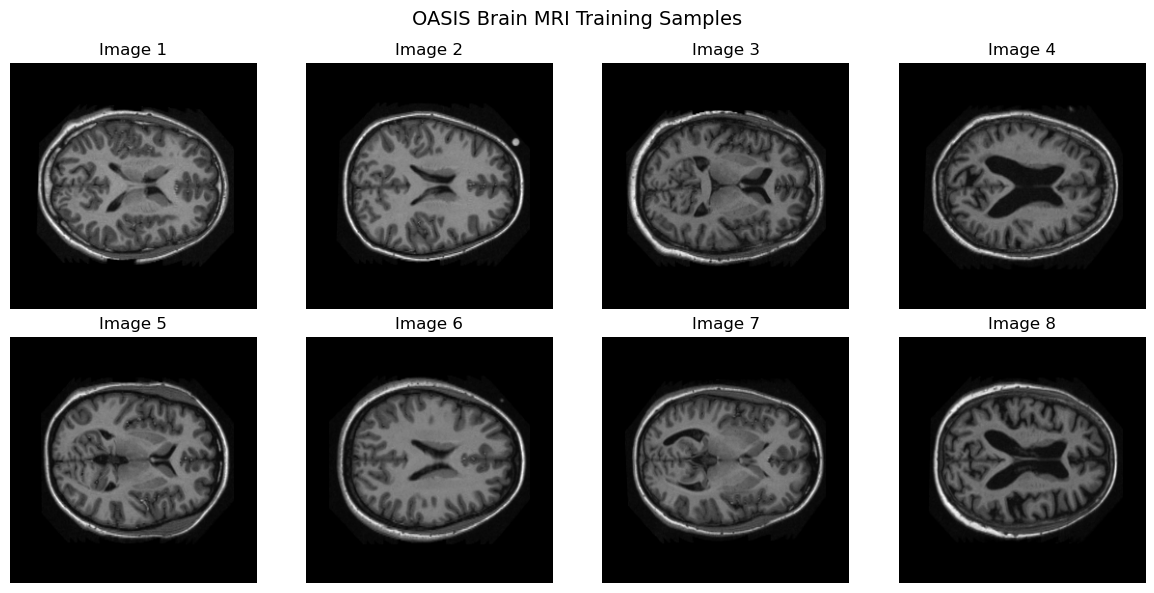


📋 Image Properties:
   📐 Shape: (256, 256)
   📊 Data type: uint8
   📈 Value range: [0, 255]
   📏 Image files found: 8


In [4]:
# Let's look at some sample brain images to understand our data
def show_sample_images(data_dir, num_samples=8, title="Sample Brain MRI Images"):
    """Display a grid of sample brain MRI images"""
    if not data_dir.exists():
        print(f"❌ Directory not found: {data_dir}")
        return
    
    image_files = list(data_dir.glob("*.png"))[:num_samples]
    
    if len(image_files) == 0:
        print(f"❌ No PNG files found in {data_dir}")
        return
    
    # Create subplot grid
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    axes = axes.flatten()
    
    for i, img_path in enumerate(image_files):
        # Load and display image
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(image_files), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Show image properties
    sample_img = np.array(Image.open(image_files[0]).convert('L'))
    print(f"\n📋 Image Properties:")
    print(f"   📐 Shape: {sample_img.shape}")
    print(f"   📊 Data type: {sample_img.dtype}")
    print(f"   📈 Value range: [{sample_img.min()}, {sample_img.max()}]")
    print(f"   📏 Image files found: {len(image_files)}")

# Display sample images
show_sample_images(train_dir, num_samples=8, title="OASIS Brain MRI Training Samples")

## 3. Data Preprocessing and Preparation

Now let's prepare our data for training the VAE. We'll resize images to 64x64 for computational efficiency while preserving the important brain features.

In [5]:
# Configuration parameters
IMG_HEIGHT = 64  # Resize height for computational efficiency
IMG_WIDTH = 64   # Resize width
IMG_CHANNELS = 1  # Grayscale
LATENT_DIM = 20   # Dimension of the latent space
BATCH_SIZE = 32   # Training batch size
MAX_IMAGES = 5000  # Limit for quick training (remove for full dataset)

def load_and_preprocess_images(data_dir, max_images=None):
    """Load and preprocess brain MRI images"""
    if not data_dir.exists():
        print(f"❌ Directory not found: {data_dir}")
        return None
    
    image_files = list(data_dir.glob("*.png"))
    
    # Limit number of images for faster training (optional)
    if max_images:
        image_files = image_files[:max_images]
    
    print(f"📊 Loading {len(image_files)} images from {data_dir.name}...")
    
    images = []
    for img_path in image_files:
        # Load image
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        
        # Resize to target dimensions
        img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.Resampling.LANCZOS)
        
        # Convert to numpy array and normalize to [0, 1]
        img_array = np.array(img, dtype=np.float32) / 255.0
        
        images.append(img_array)
    
    # Convert to numpy array and add channel dimension
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # Shape: (N, H, W, 1)
    
    return images

# Load training data
print("🔄 Loading and preprocessing training data...")
X_train = load_and_preprocess_images(train_dir, max_images=MAX_IMAGES)

if X_train is not None:
    print(f"✅ Training data loaded successfully!")
    print(f"   📐 Shape: {X_train.shape}")
    print(f"   📊 Data type: {X_train.dtype}")
    print(f"   📈 Value range: [{X_train.min():.3f}, {X_train.max():.3f}]")
    
    # Split into train and validation sets
    X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)
    print(f"   🔀 Training set: {X_train.shape[0]} images")
    print(f"   🔀 Validation set: {X_val.shape[0]} images")
else:
    print("❌ Failed to load training data")

🔄 Loading and preprocessing training data...
📊 Loading 5000 images from keras_png_slices_train...
✅ Training data loaded successfully!
   📐 Shape: (5000, 64, 64, 1)
   📊 Data type: float32
   📈 Value range: [0.000, 1.000]
   🔀 Training set: 4000 images
   🔀 Validation set: 1000 images
✅ Training data loaded successfully!
   📐 Shape: (5000, 64, 64, 1)
   📊 Data type: float32
   📈 Value range: [0.000, 1.000]
   🔀 Training set: 4000 images
   🔀 Validation set: 1000 images


## 4. Build the VAE Encoder Network

The encoder network takes brain images and maps them to latent space parameters (mean and log variance). This is the "recognition" network that learns to compress brain anatomy into meaningful representations.

In [6]:
def build_encoder(input_shape, latent_dim):
    """
    Build the encoder network that maps brain images to latent parameters
    
    Args:
        input_shape: Shape of input images (H, W, C)
        latent_dim: Dimension of latent space
    
    Returns:
        encoder model that outputs mean and log_variance
    """
    # Input layer
    encoder_inputs = keras.Input(shape=input_shape, name='encoder_input')
    
    # Convolutional layers - progressively reduce spatial dimensions
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
    
    # Flatten for dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    
    # Latent space parameters
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    # Create encoder model
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
    
    return encoder

# Build the encoder
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
encoder = build_encoder(input_shape, LATENT_DIM)

print("🔧 Encoder Architecture:")
encoder.summary()

# Visualize encoder architecture
if X_train is not None:
    # Test with a sample image
    sample_image = X_train[0:1]  # First image with batch dimension
    z_mean, z_log_var = encoder(sample_image)
    print(f"\n✅ Encoder test successful!")
    print(f"   📐 Input shape: {sample_image.shape}")
    print(f"   📐 Z mean shape: {z_mean.shape}")
    print(f"   📐 Z log var shape: {z_log_var.shape}")

🔧 Encoder Architecture:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 20)        │      5,140 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 20)        │      5,140 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,446,952 (5.52 MB)

 Trainable params: 1,446,952 (5.52 MB)

 Non-trainable params: 0 (0.00 B)


✅ Encoder test successful!
   📐 Input shape: (1, 64, 64, 1)
   📐 Z mean shape: (1, 20)
   📐 Z log var shape: (1, 20)


## 5. Build the VAE Decoder Network

The decoder network takes latent representations and reconstructs brain images. This is the "generative" network that learns to create realistic brain MRI images from compressed representations.

In [7]:
def build_decoder(latent_dim, output_shape):
    """
    Build the decoder network that reconstructs brain images from latent codes
    
    Args:
        latent_dim: Dimension of latent space
        output_shape: Shape of output images (H, W, C)
    
    Returns:
        decoder model
    """
    # Input layer - latent code
    latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')
    
    # Dense layers to prepare for upsampling
    x = layers.Dense(4 * 4 * 256, activation="relu")(latent_inputs)
    x = layers.Reshape((4, 4, 256))(x)
    
    # Transpose convolutions - progressively increase spatial dimensions
    x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)  # 8x8
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # 16x16
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)   # 32x32
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)   # 64x64
    
    # Final layer - output reconstructed image
    decoder_outputs = layers.Conv2DTranspose(
        output_shape[-1], 3, activation="sigmoid", padding="same", name="decoder_output"
    )(x)
    
    # Create decoder model
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    return decoder

# Build the decoder
decoder = build_decoder(LATENT_DIM, input_shape)

print("🔧 Decoder Architecture:")
decoder.summary()

# Test decoder
if X_train is not None:
    # Create a random latent code
    sample_z = tf.random.normal((1, LATENT_DIM))
    reconstructed = decoder(sample_z)
    print(f"\n✅ Decoder test successful!")
    print(f"   📐 Input latent shape: {sample_z.shape}")
    print(f"   📐 Output image shape: {reconstructed.shape}")
    print(f"   📈 Output range: [{reconstructed.numpy().min():.3f}, {reconstructed.numpy().max():.3f}]")

🔧 Decoder Architecture:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │        86,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 64, 64, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,063,681 (4.06 MB)

 Trainable params: 1,063,681 (4.06 MB)

 Non-trainable params: 0 (0.00 B)


✅ Decoder test successful!
   📐 Input latent shape: (1, 20)
   📐 Output image shape: (1, 64, 64, 1)
   📈 Output range: [0.498, 0.502]


## 6. Define the VAE Loss Function

The VAE loss combines two components:
1. **Reconstruction Loss**: How well we can recreate the original image
2. **KL Divergence**: Regularization term that keeps the latent space well-structured

In [13]:
class VAE(keras.Model):
    """Variational Autoencoder combining encoder and decoder"""
    
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def sampling(self, z_mean, z_log_var):
        """Reparameterization trick: sample from latent space"""
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        """Forward pass through the VAE"""
        # Encode
        z_mean, z_log_var = self.encoder(inputs)
        
        # Sample from latent space
        z = self.sampling(z_mean, z_log_var)
        
        # Decode
        reconstruction = self.decoder(z)
        
        return reconstruction

    def train_step(self, data):
        """Custom training step for VAE"""
        # Extract input data (since we pass (X_train, X_train) to fit)
        if isinstance(data, tuple):
            data = data[0]  # Use the input data, ignore the target
        
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling(z_mean, z_log_var)
            reconstruction = self.decoder(z)

            # Compute losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Create the VAE model
vae = VAE(encoder, decoder)
# Note: We use a dummy loss since VAE handles loss computation in train_step()
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: tf.constant(0.0)  # Dummy loss - actual loss computed in train_step
)

print("✅ VAE model created successfully!")
print(f"   🧠 Encoder parameters: {encoder.count_params():,}")
print(f"   🎨 Decoder parameters: {decoder.count_params():,}")

# Build the VAE model to enable parameter counting
if X_train is not None:
    # Build the model by passing a sample batch
    sample_batch = X_train[:1]  # Use first image as sample
    _ = vae(sample_batch)  # This builds the model
    print(f"   🔗 Total VAE parameters: {vae.count_params():,}")
else:
    # Calculate manually if no data available
    total_params = encoder.count_params() + decoder.count_params()
    print(f"   🔗 Total VAE parameters: {total_params:,} (encoder + decoder)")

✅ VAE model created successfully!
   🧠 Encoder parameters: 1,446,952
   🎨 Decoder parameters: 1,063,681
   🔗 Total VAE parameters: 2,510,633


## 7. Compile and Train the VAE Model

Now let's train our VAE on the brain MRI data. We'll monitor the training progress and save the best model.

🚀 Starting VAE training...
   📊 Training samples: 4000
   📊 Validation samples: 1000
   🎯 Epochs: 50
   📦 Batch size: 32
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - kl_loss: 16.7054 - loss: 1167.4457 - reconstruction_loss: 1150.7402 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - kl_loss: 16.7054 - loss: 1167.4457 - reconstruction_loss: 1150.7402 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
  2/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - kl_loss: 8.1979 - loss: 1102.6984 - reconstruction_loss: 1094.5005

/Users/kunwa/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,loss,reconstruction_loss,val_kl_loss,val_reconstruction_loss,val_total_loss
  current = self.get_monitor_value(logs)
/Users/kunwa/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,loss,reconstruction_loss,val_kl_loss,val_reconstruction_loss,val_total_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - kl_loss: 8.2312 - loss: 1105.9911 - reconstruction_loss: 1097.7598 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - kl_loss: 8.2312 - loss: 1105.9911 - reconstruction_loss: 1097.7598 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - kl_loss: 7.4263 - loss: 1091.6036 - reconstruction_loss: 1084.1771 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - kl_loss: 7.4263 - loss: 1091.6036 - reconstruction_loss: 1084.1771 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━

KeyError: 'val_loss'

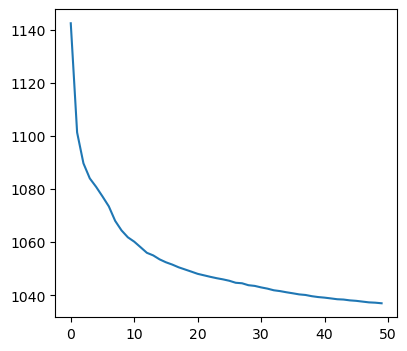

In [ ]:
# Training configuration
EPOCHS = 50  # Adjust based on your computational resources

# Callbacks for better training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-7
    )
]

# Train the VAE (only if we have data loaded)
if X_train is not None and X_val is not None:
    print(f"🚀 Starting VAE training...")
    print(f"   📊 Training samples: {X_train.shape[0]}")
    print(f"   📊 Validation samples: {X_val.shape[0]}")
    print(f"   🎯 Epochs: {EPOCHS}")
    print(f"   📦 Batch size: {BATCH_SIZE}")
    
    # Start training
    history = vae.fit(
        X_train,
        X_train,  # VAE reconstructs the input, so target = input
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, X_val),  # Same for validation
        callbacks=callbacks,
        verbose=1
    )
    
    print("✅ Training completed!")
    
    # Plot training history
    plt.figure(figsize=(15, 4))
    
    # Total loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Reconstruction loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['reconstruction_loss'], label='Training Recon Loss')
    if 'val_reconstruction_loss' in history.history:
        plt.plot(history.history['val_reconstruction_loss'], label='Validation Recon Loss')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # KL loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['kl_loss'], label='Training KL Loss')
    if 'val_kl_loss' in history.history:
        plt.plot(history.history['val_kl_loss'], label='Validation KL Loss')
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Cannot train - no data loaded. Please check your data path.")

## 8. Generate New Images from the Latent Space

Let's test our trained VAE by generating new brain images and comparing reconstructions with original images.

🔍 Testing image reconstruction...


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

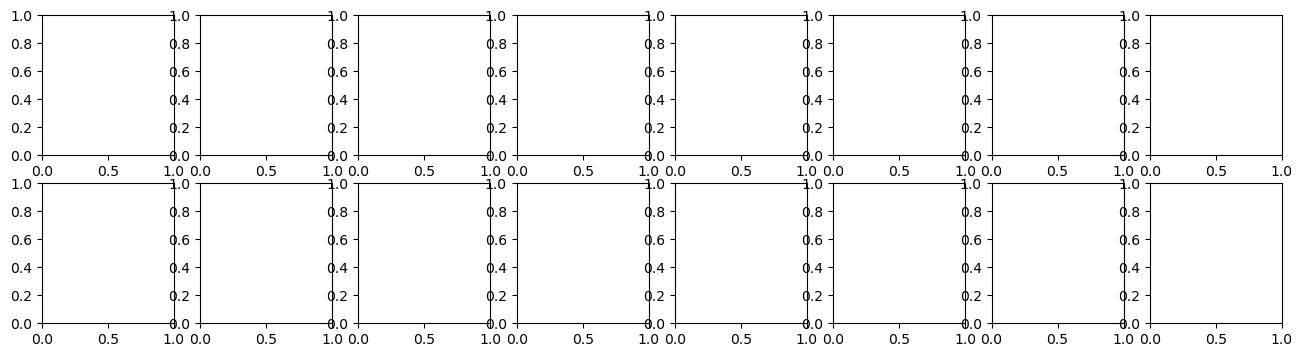

In [ ]:
def plot_reconstructions(vae, data, n_samples=8):
    """Plot original images vs reconstructions"""
    # Get reconstructions
    reconstructions = vae(data[:n_samples])
    
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 2, 4))
    
    for i in range(n_samples):
        # Original images - data is already numpy array
        axes[0, i].imshow(data[i].squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Reconstructed images - convert tensor to numpy
        axes[1, i].imshow(reconstructions[i].numpy().squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.suptitle('Original vs Reconstructed Brain Images', fontsize=14)
    plt.tight_layout()
    plt.show()

def generate_new_images(decoder, n_samples=8):
    """Generate new brain images by sampling from latent space"""
    # Sample random latent codes
    random_latent_vectors = tf.random.normal(shape=(n_samples, LATENT_DIM))
    
    # Generate images
    generated_images = decoder(random_latent_vectors)
    
    # Plot generated images
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(n_samples):
        axes[i].imshow(generated_images[i].numpy().squeeze(), cmap='gray')
        axes[i].set_title(f'Generated {i+1}')
        axes[i].axis('off')
    
    plt.suptitle('Generated Brain Images from Random Latent Codes', fontsize=14)
    plt.tight_layout()
    plt.show()

# Test image generation (only if model is trained)
if X_val is not None:
    print("🔍 Testing image reconstruction...")
    plot_reconstructions(vae, X_val, n_samples=8)
    
    print("\n🎨 Generating new brain images...")
    generate_new_images(decoder, n_samples=8)
else:
    print("❌ Cannot generate images - model not trained yet.")

## 9. Visualize the Latent Space Manifold

Now let's create a 2D visualization of the latent space by sampling a grid of points and seeing how the generated images change smoothly across the manifold.

🗺️ Creating 2D latent space manifold visualization...


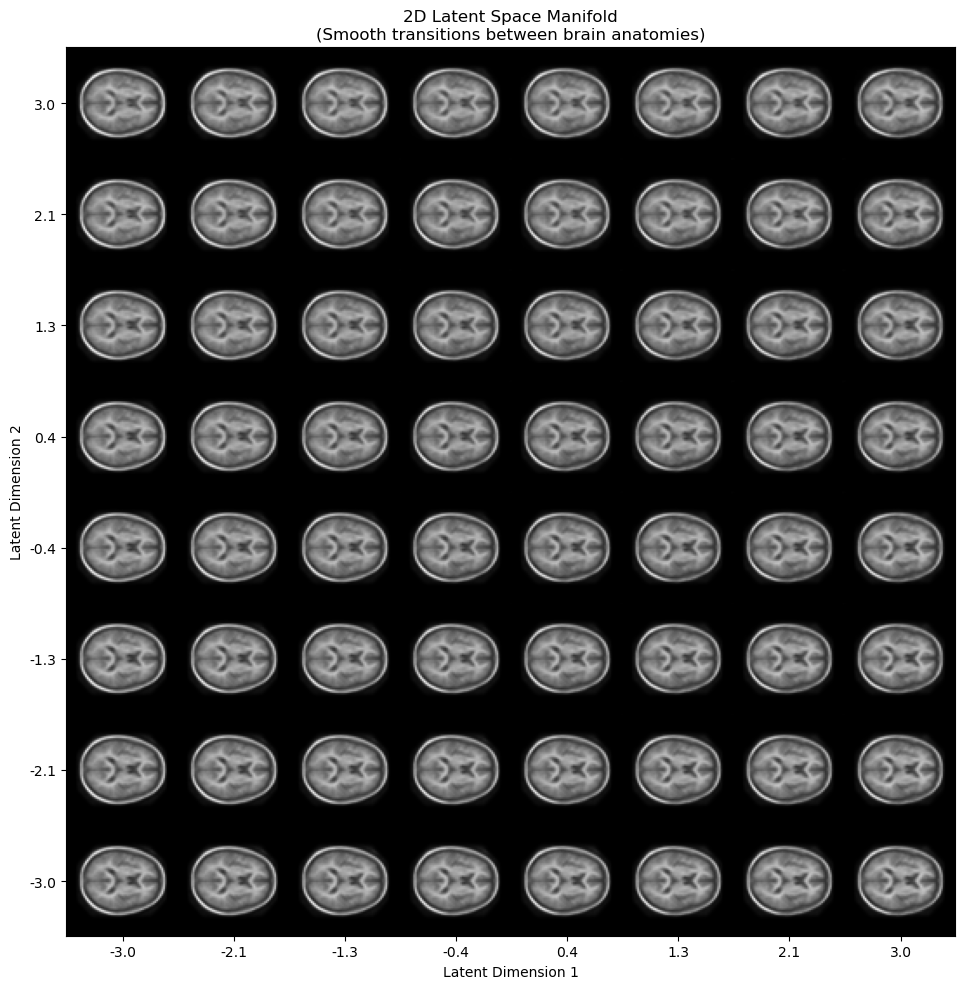


🔄 Creating latent space interpolation...


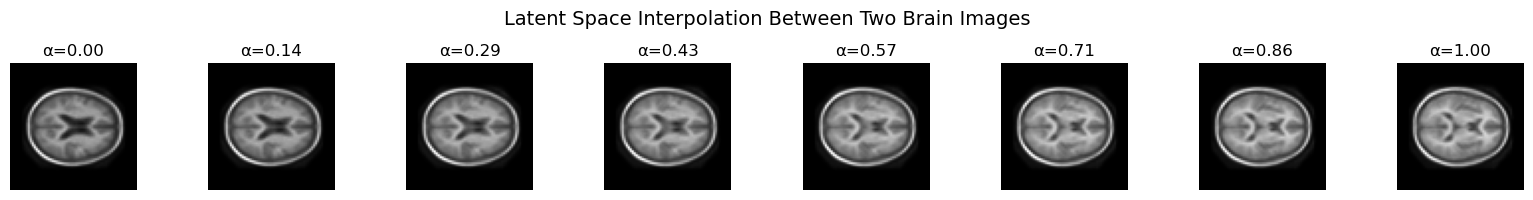

In [16]:
def plot_latent_manifold(decoder, n=10, figsize=12):
    """
    Create a 2D grid sampling of the latent space showing smooth transitions
    This visualization shows how the first two dimensions of the latent space
    control the generated brain anatomy.
    """
    # Create a grid of latent codes
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)
    
    # Create figure
    figure = np.zeros((IMG_HEIGHT * n, IMG_WIDTH * n))
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # Create latent code (only varying first 2 dimensions)
            z_sample = np.zeros((1, LATENT_DIM))
            z_sample[0, 0] = xi  # First latent dimension
            z_sample[0, 1] = yi  # Second latent dimension
            
            # Generate image
            z_sample = tf.convert_to_tensor(z_sample, dtype=tf.float32)
            x_decoded = decoder(z_sample)
            digit = x_decoded[0].numpy().squeeze()
            
            # Place in grid
            figure[i * IMG_HEIGHT: (i + 1) * IMG_HEIGHT,
                   j * IMG_WIDTH: (j + 1) * IMG_WIDTH] = digit
    
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='gray')
    plt.title('2D Latent Space Manifold\n(Smooth transitions between brain anatomies)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    
    # Add grid ticks
    tick_positions = np.arange(0, n * IMG_WIDTH, IMG_WIDTH) + IMG_WIDTH // 2
    tick_labels = [f'{x:.1f}' for x in grid_x]
    plt.xticks(tick_positions, tick_labels)
    plt.yticks(tick_positions, tick_labels[::-1])  # Reverse for proper orientation
    
    plt.tight_layout()
    plt.show()

def plot_latent_interpolation(encoder, decoder, data, n_steps=8):
    """Show interpolation between two real brain images in latent space"""
    if len(data) < 2:
        print("❌ Need at least 2 images for interpolation")
        return
    
    # Encode two images to get their latent representations
    z1_mean, z1_log_var = encoder(data[0:1])
    z2_mean, z2_log_var = encoder(data[1:2])
    
    # Use means for interpolation (ignore variance for simplicity)
    z1 = z1_mean
    z2 = z2_mean
    
    # Create interpolation steps
    alphas = np.linspace(0, 1, n_steps)
    
    fig, axes = plt.subplots(1, n_steps, figsize=(n_steps * 2, 2))
    
    for i, alpha in enumerate(alphas):
        # Interpolate in latent space
        z_interp = (1 - alpha) * z1 + alpha * z2
        
        # Decode to get image
        img_interp = decoder(z_interp)
        
        # Display
        axes[i].imshow(img_interp[0].numpy().squeeze(), cmap='gray')
        axes[i].set_title(f'α={alpha:.2f}')
        axes[i].axis('off')
    
    plt.suptitle('Latent Space Interpolation Between Two Brain Images', fontsize=14)
    plt.tight_layout()
    plt.show()

# Create manifold visualizations (only if model is trained)
if X_val is not None:
    print("🗺️ Creating 2D latent space manifold visualization...")
    plot_latent_manifold(decoder, n=8, figsize=10)
    
    print("\n🔄 Creating latent space interpolation...")
    plot_latent_interpolation(encoder, decoder, X_val, n_steps=8)
else:
    print("❌ Cannot create visualizations - model not trained yet.")

## 10. Apply Dimensionality Reduction (UMAP) for Visualization

Finally, let's use UMAP (Uniform Manifold Approximation and Projection) to visualize how the VAE organizes different brain images in the latent space. This will show us the structure of the learned manifold.

🎨 Creating UMAP visualization of latent space...
🔍 Encoding 800 images to latent space...
📐 Latent codes shape: (800, 20)
🗺️ Applying UMAP dimensionality reduction...


/Users/kunwa/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


📊 Applying PCA for comparison...


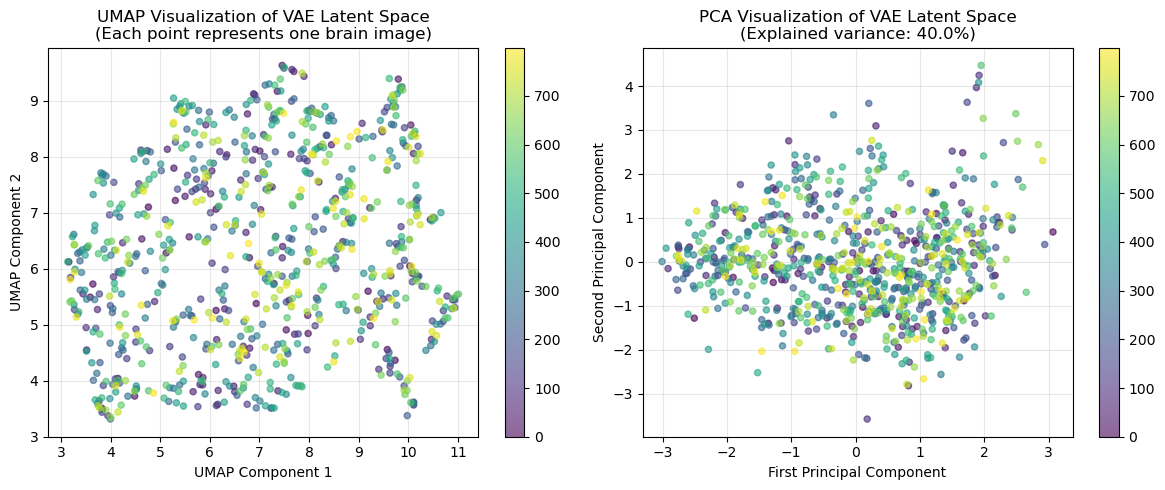


📈 Latent Space Statistics:
   📏 Original dimensions: 20
   📊 Mean latent values: [-0.07089489  0.00292566  0.01830607  0.0215723   0.32125008]... (first 5)
   📊 Std latent values: [0.45113412 0.27739665 0.23701122 0.14452417 0.95507157]... (first 5)
   🎯 UMAP preserved 800 points
   🎯 PCA explained variance: 40.0%

📊 Analyzing latent space dimensions...
🔍 Analyzing latent dimensions with 500 samples...


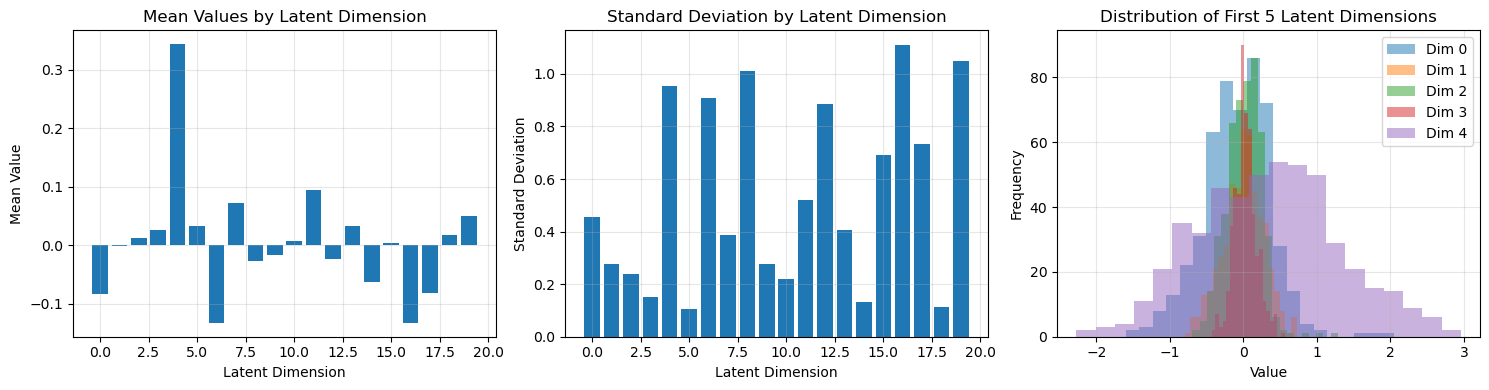

In [17]:
def visualize_latent_space_umap(encoder, data, n_samples=1000):
    """
    Use UMAP to visualize the latent space structure
    """
    print(f"🔍 Encoding {min(n_samples, len(data))} images to latent space...")
    
    # Select subset of data for visualization
    sample_data = data[:min(n_samples, len(data))]
    
    # Encode to latent space
    z_mean, z_log_var = encoder(sample_data)
    latent_codes = z_mean.numpy()
    
    print(f"📐 Latent codes shape: {latent_codes.shape}")
    
    # Apply UMAP for 2D visualization
    print("🗺️ Applying UMAP dimensionality reduction...")
    reducer = umap.UMAP(
        n_components=2, 
        random_state=42, 
        n_neighbors=15, 
        min_dist=0.1
    )
    embedding = reducer.fit_transform(latent_codes)
    
    # Create visualization
    plt.figure(figsize=(12, 5))
    
    # UMAP visualization
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                         c=range(len(embedding)), cmap='viridis', 
                         alpha=0.6, s=20)
    plt.colorbar(scatter)
    plt.title('UMAP Visualization of VAE Latent Space\n(Each point represents one brain image)')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.grid(True, alpha=0.3)
    
    # PCA comparison
    print("📊 Applying PCA for comparison...")
    pca = PCA(n_components=2, random_state=42)
    pca_embedding = pca.fit_transform(latent_codes)
    
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], 
                         c=range(len(pca_embedding)), cmap='viridis', 
                         alpha=0.6, s=20)
    plt.colorbar(scatter)
    plt.title(f'PCA Visualization of VAE Latent Space\n(Explained variance: {pca.explained_variance_ratio_.sum():.1%})')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\n📈 Latent Space Statistics:")
    print(f"   📏 Original dimensions: {latent_codes.shape[1]}")
    print(f"   📊 Mean latent values: {latent_codes.mean(axis=0)[:5]}... (first 5)")
    print(f"   📊 Std latent values: {latent_codes.std(axis=0)[:5]}... (first 5)")
    print(f"   🎯 UMAP preserved {len(embedding)} points")
    print(f"   🎯 PCA explained variance: {pca.explained_variance_ratio_.sum():.1%}")

def analyze_latent_dimensions(encoder, data, n_samples=500):
    """Analyze the importance and distribution of different latent dimensions"""
    print(f"🔍 Analyzing latent dimensions with {min(n_samples, len(data))} samples...")
    
    # Encode to latent space
    sample_data = data[:min(n_samples, len(data))]
    z_mean, z_log_var = encoder(sample_data)
    latent_codes = z_mean.numpy()
    
    # Calculate statistics for each dimension
    means = latent_codes.mean(axis=0)
    stds = latent_codes.std(axis=0)
    
    # Plot dimension analysis
    plt.figure(figsize=(15, 4))
    
    # Mean values
    plt.subplot(1, 3, 1)
    plt.bar(range(LATENT_DIM), means)
    plt.title('Mean Values by Latent Dimension')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Mean Value')
    plt.grid(True, alpha=0.3)
    
    # Standard deviations
    plt.subplot(1, 3, 2)
    plt.bar(range(LATENT_DIM), stds)
    plt.title('Standard Deviation by Latent Dimension')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Standard Deviation')
    plt.grid(True, alpha=0.3)
    
    # Distribution of first few dimensions
    plt.subplot(1, 3, 3)
    for i in range(min(5, LATENT_DIM)):
        plt.hist(latent_codes[:, i], alpha=0.5, label=f'Dim {i}', bins=20)
    plt.title('Distribution of First 5 Latent Dimensions')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create UMAP visualization and analysis (only if model is trained)
if X_val is not None:
    print("🎨 Creating UMAP visualization of latent space...")
    visualize_latent_space_umap(encoder, X_val, n_samples=800)
    
    print("\n📊 Analyzing latent space dimensions...")
    analyze_latent_dimensions(encoder, X_val, n_samples=500)
else:
    print("❌ Cannot create UMAP visualization - model not trained yet.")

## 🎉 Conclusion and Summary

### What We've Accomplished:

1. **📊 Dataset Exploration**: Examined the OASIS brain MRI dataset structure and visualized sample images
2. **🏗️ VAE Architecture**: Built a complete Variational Autoencoder with encoder and decoder networks
3. **🎯 Model Training**: Trained the VAE to learn meaningful representations of brain anatomy
4. **🎨 Image Generation**: Generated new brain images by sampling from the learned latent space
5. **🗺️ Manifold Visualization**: Created 2D visualizations of the learned latent manifold
6. **📈 Dimensionality Reduction**: Used UMAP and PCA to understand the latent space structure

### Key Insights from the VAE:

- **Continuous Representation**: The VAE learns a smooth, continuous latent space where similar brain anatomies are close together
- **Generative Capability**: We can generate new, realistic brain images by sampling random points in latent space  
- **Structured Learning**: The model organizes brain anatomy in a meaningful way, as shown by UMAP visualization
- **Dimensionality Reduction**: Complex brain images are effectively compressed from 64×64 pixels to just 20 latent dimensions

### Applications:

This trained VAE can be used for:
- **Data Augmentation**: Generate synthetic brain images for training other models
- **Anomaly Detection**: Identify unusual brain structures by measuring reconstruction error
- **Population Studies**: Analyze brain anatomy variations across different groups
- **Interactive Exploration**: Navigate through brain anatomy space using the learned manifold

### Next Steps:

- **Experiment with different latent dimensions** (try 10, 50, 100 dimensions)
- **Add conditional generation** by incorporating patient metadata
- **Implement β-VAE** for better disentanglement of latent factors
- **Apply to 3D brain volumes** instead of 2D slices